# Compare more than 2 models

The method F-test can be used to compare 2 or more classifiers.

A null hypothesys is an hypothesys presented on estatistical facts. The objective is trying to prove its falsity.
In this case, we are trying to prove that there is no important difference between multiple classifiers, by looking at their predicted data.

## Import dependencies and classifiers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
import random
import scipy.stats

#Classifiers
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Dataset
from mlxtend.data import iris_data

## Load data

Imported a small dataset with 150 examples and 3 classes.
Keeped only 2 features so that we can visualize the data.
Divided the data into train (100 examples) and validation(50)

In [2]:
#Load Data
X, y = iris_data()
X = X[:,[0, 2]]     #Easy to visualize

#Divide data into Train and Validation
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)
X, y = np.array(list(X)), np.array(list(y))

X_val = X[:50]
X = X[50:]

y_val = y[:50]
y = y[50:]

## Initialize Classifiers

We will compare 5 classifiers:
 - SVM linear
 - SVM RBF
 - Linear Discriminant
 - KNN
 - Perceptron

In [3]:
# Initializing Classifiers
clf1 = SVC(kernel='linear')
clf2 = SVC(kernel='rbf')
clf3 = LinearDiscriminantAnalysis()
clf4 = KNeighborsClassifier(n_neighbors=3)
clf5 = Perceptron()

labels = ['SVM linear',
          'SVM RBF',
          'LinearDiscriminantAnalysis',
          'KNN',
          'Perceptron']

## Plot data

To have a better understanding on the similarity of the models we included a plot on the several trained models

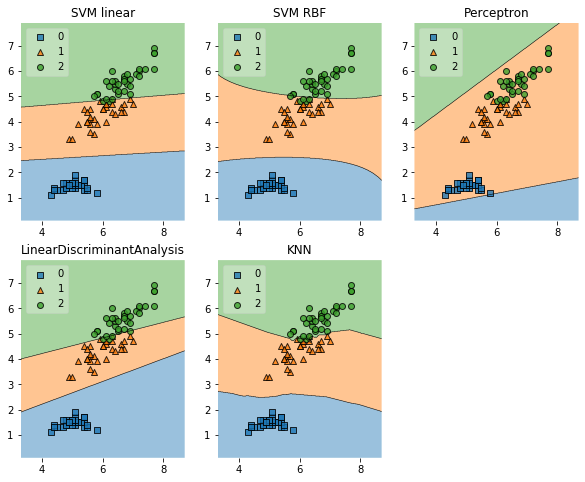

In [4]:

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(10, 8))
preds = []
                       
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1), (0,2)]):
                       
    clf.fit(X, y) #FIT model
    preds.append(np.array(clf.predict(X_val))) #MakePredictions

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y,
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()



Normally peceptron will not be able to fit the data very well.

## F-Test

In [5]:
def f_test(y_true, *y_models):
    n = len(y_true)
    m = len(y_models)

    avgACC = sum([accuracy_score(y_true, y) for y in y_models]) / m

    gjSum = sum([((y_true == ypred).sum() / n)**2 for ypred in y_models])
    ssa = n * gjSum - n * m * avgACC**2

    mjSum = 0
    for i in range(n):
        y = y_true[i]
        count = 0
        for ypred in y_models:
            if y == ypred[i]:
                count += 1
        mjSum += count**2
    ssb = 1/m * mjSum - m * n * avgACC**2

    sst = m * n * avgACC*(1-avgACC)

    ssab = sst - ssa - ssb

    msa = ssa / (m-1)

    msab = ssab / ((m-1) * (n-1))

    f = msa / msab

    degrees_of_freedom_1 = m - 1
    degrees_of_freedom_2 = degrees_of_freedom_1 * n

    p_value = scipy.stats.f.sf(f, degrees_of_freedom_1, degrees_of_freedom_2)

    return f, p_value

In [6]:
def nullHyp(p_value):
    if p_value < 0.05:   #significance level α=0.05
        print("Rejected the null hypothesys") #there is a difference between the classification accuracies
    else:
        print("Accepted the null hypothesys") #There is no difference between the classification accuracies

## Compare models

In [7]:
#TRY WITHOUT PECEPTRON

f, p_value = f_test(y_val, preds[0],preds[1],preds[2],preds[3])
print('F: %.3f' % f)
print('p-value: %.3f' % p_value)
nullHyp(p_value)


F: 2.160
p-value: 0.095
Accepted the null hypothesys


In [8]:
#TRY WITH PECEPTRON

f, p_value = f_test(y_val, preds[0],preds[1],preds[2],preds[3], preds[4])
print('F: %.3f' % f)
print('p-value: %.3f' % p_value)
nullHyp(p_value)

F: 47.511
p-value: 0.000
Rejected the null hypothesys


As we can see (most of the times), in the comparison between the first 4 classifiers, we accepted the null hypothesys, meaning that there is no important difference between the classification accuracys of the models.

However, when we compare Peceptron as well, which didnt fit the data and has a bad accuracy, we can 

## Evaluate two models with 5x2cv combined F-test

In [10]:
from mlxtend.evaluate import combined_ftest_5x2cv

score1 = clf1.fit(X, y).score(X_val, y_val)
print('Linear SVM accuracy: %.2f%%' % (score1*100))

score2 = clf5.fit(X, y).score(X_val, y_val)
print('Perceptron accuracy: %.2f%%\n' % (score2*100))


f, p = combined_ftest_5x2cv(estimator1=clf1,
                            estimator2=clf2,
                            X=X, y=y,
                            random_seed=1)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)
nullHyp(p)

Linear SVM accuracy: 94.00%
Perceptron accuracy: 36.00%

F statistic: 1.000
p value: 0.535
Accepted the null hypothesys


### Evaluation analysis

As we can see, the perceptron gives off the worst results, since its accuracy to the testing data is only 58%, while the others are in the range of 95-98% accuracy